# Project Adv ML

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy import special
import pandas as pd
import nltk

### Setup

## Load the Document Corpus
Download the data from 
https://github.com/Blei-Lab/lda-c/blob/master/example/ap.tgz

We can directly load the file "ap.dat" which contains:

1 line = 1 document,

[number of different words in doc] [word index (where the one is in w_n]:[how often it occurs in the doc] [word index 2]:[occurences 2] ...

In [2]:
vocab = pd.read_csv("./ap/vocab.txt", header=None)
V = vocab.shape[0] # Vocabulary size given by vocab_list.txt
#vocab.head(10)

In [3]:
data = pd.read_csv('ap/ap.dat', sep="#", names=['A'])
M = data.shape[0]
data = data.A.str.split(' ')
doc_word_count = np.zeros((M, V))

for j, m in enumerate(data):
    count = m.pop(0)
    for i in range(int(count)):
        type(m[i])
        cur = m[i].split(":")
        doc_word_count[j][int(cur[0])] = int(cur[1])

In [4]:
data = pd.read_csv('ap/ap.dat', sep="#", names=['A'])
data = data.A.str.split(' |:', n=V, expand=True)
data.head()
data_np = data.values

In [5]:
D = []  # this has dim: M x 2 (words and counts) x N_words(document)
for w in range(M): # for each document
    doc_string = data_np[w,:]
    #print(len(doc_string))
    word_indices = doc_string[1::2]
    #print("word_indices", word_indices)
    counts = doc_string[2::2]
    #if w==1:
    #  print(len(word_indices), len(counts))
    #print("counts", counts)
    N_different_words_in_this_doc = doc_string[0] # not needed.
    D.append([])
    all_words = []
    for n,word in enumerate(word_indices):
        if word == None:
            break
        for repetition in range(int(counts[n])):
            #if int(counts[n])>1:
            #  print(word, counts[n])
            all_words.append(int(word))
    D[-1] = all_words
  # NOTE: D does not contain M docs with each N_d words, where each word w_n is a V-dim vector.
  # BUT:              it has M docs with each N_d words, where each word is just the unique index v, that is one of the V-dim vector.
  # Reason: V=10,000...


In [6]:
M, V

(2246, 10473)

Text(0, 0.5, 'count')

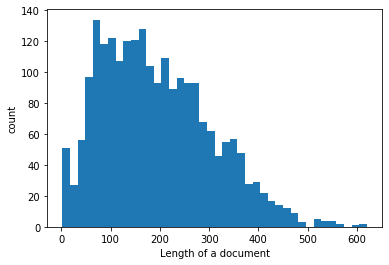

In [7]:
lengths = []
for i in range(len(D)):
    lengths.append(len(D[i]))
p = plt.hist(lengths, bins=40)
plt.xlabel("Length of a document")
plt.ylabel("count")



## Remove the standard words and load new Dataset (Reuters)

#### Import the Natural Langauge Processing Package
This provides the Reuters articles

In [8]:
#nltk.download("popular")

#### Download the reuters data, if not already downloaded

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import reuters

# If you run this cell for the first time, uncomment the following line to download the corpus
#nltk.download('reuters')
#reuters.fileids()

The variable reuters consists of 10788 documents, with a few labeled as test and 7769 as training documents.

Below, we get the filenames of the training ones

In [10]:
training_ids = []
test_ids = []
for name in reuters.fileids():
    if "training" in name:
        training_ids.append(name)
    else:
        test_ids.append(name)
print("M_max_reuters = ", len(training_ids) )

M_max_reuters =  7769


There are more documents than in the AP example above. Hence, we choose only those 2246 documents (for now) and compare it

In [11]:
M_reuters = 20

training = includes a list of all the chosen documents. Each of these elements contains a list of all the words in the document

In [12]:
training=[]  
for i in range(M_reuters):
    #file=str(i+1)
    file = training_ids[i] # filename
    training.append(reuters.words(file)) #append the document to training

doc_lengths =  [len(training[i]) for i in range(len(training))] # this is N_d (length of each of the documents)
print("We have ", len(training), " Documents with sizes: ", doc_lengths[:100])


We have  20  Documents with sizes:  [633, 259, 119, 155, 115, 34, 250, 83, 182, 133, 126, 85, 84, 111, 99, 101, 67, 26, 73, 140]


### Actually create the dataset and vocab_list

Example:  

a sentence/document: "You have a cactus." 

    - want to remove the "you", the "a" and the "." (stopwords) 
    - add the rest to my vocab_list ie. vocab_list= ["have", "cactus"].
    - Then, store the document as a list of indices from my vocab: Ie. the document above is stored as [0,1].
- the Vocab is a list of all the (non-unnecessary) words in the corpus


In [13]:
vocab_list=[] # 

def create_dict(data, test = True):     
    global vocab_list # change the global vocab_list
    D=[]  # dim = (#documents, #N_reduced_d),    where N_reduced_d is the Nr of words that are not filtered / are not unnecessary
    for d in data: # for each document
        # Uncomment 3 lines below to test the function with the string below 
        # test=True
        if test==False: 
           d = " ".join(d)
        d = " ".join(d)
        dclean = remove_unnecessary_words(d)   # list of all the non-unnecessary words of the document
        d_vocabInd = []  # This is the document in terms of the indices of the words in the vocab_list (example above: [0,1])
        for w in dclean:  # loop through these words
            w = w.lower() 
            if w in vocab_list: 
                pass # word is already in vocab_list
            else:
                #add word to vocab_list
                vocab_list.append(w)
            
            # Store the word as the document
            v = vocab_list.index(w) #index v
            d_vocabInd.append(v)
            
        D.append(d_vocabInd)   # Add document to corpus
    return D


def remove_unnecessary_words(document):
    words = word_tokenize(document)
    wordsFiltered = []
    for w in words:
        if conditions(w):  # all the conditions what define an unnecessary word
            # word is not unnecessary --> add to cleaned document
            wordsFiltered.append(w)
            
    return wordsFiltered


def conditions(word):
    '''Return True if all conditions are fulfilled'''
    Cond=True
    # Word is no stopword
    Cond *= (word not in stopwords.words('english'))
    # Word is no special sign (like ".")
    Cond *= (word not in ['.', ',', ';', '-', '+', \
                             '?', '!', '=', '(', ')', \
                            '/', '&', '$', '€'])
    # Word is no float ("4.2")
    if ("." in word) or ("," in word):
        if word[0].isdecimal():
            Cond=False
    # Word is no digit
    Cond *= (not word.isdigit())
    Cond *= (not word.isdecimal())
    
    return Cond

'''TEST
data_test = ["All work and no play makes 4 jack dull boy.", 
        "All people make mistakes, but 4 5 jack makes no work.",
        "People are dull, jack makes 4.5 mistakes"]

D = create_dict(data_test)
D, vocab_list
'''

'TEST\ndata_test = ["All work and no play makes 4 jack dull boy.", \n        "All people make mistakes, but 4 5 jack makes no work.",\n        "People are dull, jack makes 4.5 mistakes"]\n\nD = create_dict(data_test)\nD, vocab_list\n'

#### Actually do the pre-processing

In [14]:
vocab_list = [] # init vocab_list
D_reuters = create_dict(training)

#print("Rows = Document[1..M] (first 100 docs only), Column = Word_in_Doc[1...N_doc], data = Index in Vocab")
#print(pd.DataFrame(D_reuters[:100], dtype=int ))
#print(vocab_list)

### Following: Just analysis of the Reuters data.

In [15]:
V_reuters = len(vocab_list)
M_reuters = len(D_reuters)
print("V ",V_reuters, ", M ", M_reuters)

V  660 , M  20


143.75 77.25


Text(0.5, 1.0, 'Reuters')

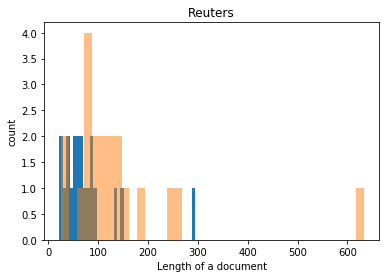

In [16]:
lengths = [] # Lengths of the cleaned documents 
for i in range(len(D_reuters)):
    lengths.append(len(D_reuters[i]))
p = plt.hist(lengths, bins=40)
p = plt.hist(doc_lengths, bins=40, alpha=0.5) # document lengths (uncleaned)

print(np.mean(doc_lengths), np.mean(lengths))

plt.xlabel("Length of a document")
plt.ylabel("count")
plt.title("Reuters")

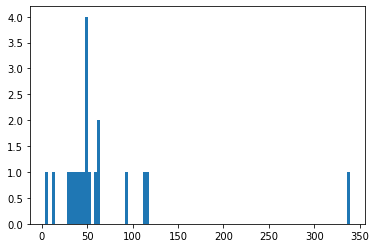

In [17]:
# How many words did the cleaning remove?
removed_words = np.array(doc_lengths)-np.array(lengths)
bla = plt.hist(removed_words, bins=100)

In [18]:
#Percentage of docs in which we removed from 20 to 100 words, and mean
print("Percentage:", np.sum(((removed_words<=100)*(removed_words>=20)))/removed_words.shape[0])
print(np.mean(removed_words), np.std(removed_words))

Percentage: 0.75
66.5 68.2601640783261


In [20]:
print("Example: ")
print("\n D AP:")
print(D[100][:15], "   Note: if the same word appears more often in the doc, it appears in direct sequence. Hence, the same index might appear multiple times in sequence")
print("\n D Reuters:")
print(D_reuters[1][:15])

Example: 

 D AP:
[0, 0, 0, 0, 0, 0, 256, 256, 256, 3, 3, 4, 4, 4, 4]    Note: if the same word appears more often in the doc, it appears in direct sequence. Hence, the same index might appear multiple times in sequence

 D Reuters:
[158, 159, 160, 161, 162, 163, 164, 165, 158, 159, 160, 166, 24, 167, 165]


### Variational Inference (the E-Step)

In [36]:
def updateGammaPhi(k, alpha, beta, w, tol=1e-5, MAX_STEPS=100, verbose=False):
    ''' This implements the update equations for Gamma and Phi for a variational inference step.
     Inputs: 
        k=int=number of topics;  
        alpha=[k]-vec=priors_of_theta(mixture_weights);  
        beta=[NxV]-matrix=prob_of_word_v_given_topic_
        w=word
    '''
    N = len(w)
    # Init    
    phi = 1/k * np.ones([N,k])
    gamma = alpha + np.ones([k]) * N/k 
    
    q_old = compute_lower_bound_likelihood(w, k, phi, gamma, alpha, beta, verbose=verbose)
    converged = False
    
    #Loop
    security_count=0
    
    while (not converged) and (security_count < MAX_STEPS):
        security_count+=1
        
        phi_old = np.copy(phi)
        logphi = np.zeros_like(phi)
        gamma_old = np.copy(gamma)
        
        for n in range(N):
            for i in range(k):
                v = w[n] ## this is not a V-Vector, but just the index of the word in the vocab
                #beta_iv is p(w_n^v = 1 | z^i = 1) 
                #unique v for each word w_n
                
                ### TRICK: instead of phi=beta+e^{psi(gamma)}, do 
                logphi[n,i] = np.log(beta[i,v]) + (psi(gamma_old[i]))#
                phi[n,i] = np.exp(logphi[n,i])
            #normalize Phi: s.t. for each topic the sum of phi[n,:] is 1.
            phi[n,:] = phi[n,:]/np.sum(phi[n,:])
        gamma = alpha + np.sum(phi,axis=0)
       
        # Convergence criterion is: lower bound of likleihood
        q_new = compute_lower_bound_likelihood(w, k, phi, gamma, alpha, beta, verbose=verbose)
        #print("Liks, ", q_new, q_old)#,  compute_lda_lhood(w,phi,gamma,alpha,beta,k))
        if abs(q_new-q_old) < tol:
            converged = True
        else: 
            q_old=np.copy(q_new)
        
    return q_new, gamma, phi

def psi(gamma_i):
    # this is the first derivative (via Taylor approximation) of the log \Gamma function
    # according to Wikipedia this is the "digamma" function
    return scipy.special.digamma(gamma_i)



In [22]:
def compute_lower_bound_likelihood(w, k, phi, gamma, alpha, beta, verbose=False):
    '''
    This calculate the lower bound of L(gamma, phi, alpha, beta)
    Ie. equation 15 in the paper in Appendix 3.
    Only one 
    '''
    
    N = len(w)
    global V # length of the vocab
    
    loggamma_sum = lambda x: scipy.special.gammaln(np.sum(x))
    loggamma_x_i = lambda x, i: np.log(scipy.special.gamma(x[i]))
    E_log_thetai_givenGamma = lambda i:  (psi(gamma[i]) - psi(np.sum(gamma))) 

    #print("gamma, alpha= ", gamma,alpha)
    L = loggamma_sum(alpha) - loggamma_sum(gamma)
    #if verbose: print("#0: ", L, end=", ")
    for i in range(k):
        L += -loggamma_x_i(alpha,i) + (alpha[i]-1)*E_log_thetai_givenGamma(i)
        L += +loggamma_x_i(gamma,i) - (gamma[i]-1)*E_log_thetai_givenGamma(i)
        #if verbose: print("#",i,": ", L, end=", ")
        for n in range(N):
            L+= phi[n,i] * E_log_thetai_givenGamma(i)
            L+= - phi[n,i] *np.log(phi[n,i])
            v = w[n] # here w_n is not a vector
            L+= phi[n,i] * np.log(beta[i,v]) 
            #if verbose: print("#",i,",",n,": ", L, ", v=",v, end=", ")
    if verbose: print(L, "\n")
    return L
    

In [23]:
def E_step(D, k, alpha, beta, MAX_COUNTER=10, verbose=False):
    gamma_list = []
    phi_list = []
    likelihood_list = []
    counter = 0
    
    for d, doc in enumerate(D):
        counter += 1
        # doc is a N_d Vector containing indices of all words
        if verbose: print("Doc: "+str(d)+" ("+str(len(doc))+")", end=", ")#, len(doc[0]))
            
        likelihood, gamma, phi = updateGammaPhi(k, alpha, beta, doc, verbose=verbose)
        gamma_list.append(gamma)
        phi_list.append(phi)
        likelihood_list.append(likelihood)
        
        # Stop this if sufficient statistics (how do i know this?)
        if verbose and counter%10 == 0:
            print(gamma, likelihood)
        # calculate the approximate q(theta, z | gamma, phi)
#         if counter> MAX_COUNTER:
#             break
    return likelihood_list, gamma_list, phi_list


## M-Step

In [53]:
def update_alpha(alpha, gamma, max_iter=50, tol=0.001):
    """This function updates alpha."""
    
    d = len(gamma)
    k = len(gamma[0])
    
    counter = 0
    check = False # flag for convergence
    
    while(not check):
        
        if np.isnan(alpha).any():
            alpha = 5 # re-intialize to avoid error
        else:
            counter += 1
                
            gradient = d * k * special.polygamma(0, k*alpha)
            gradient = gradient - d * k * special.polygamma(0, alpha)
            
            hessian = d * k * k * special.polygamma(1, k*alpha)
            hessian = hessian - d * k * special.polygamma(1, alpha)
    
            temp = gradient / (hessian * alpha + gradient)
            log_alpha = np.log(alpha) - temp
            alpha = np.exp(log_alpha)
            
            if counter == max_iter:
                check = True
            else:
                if counter > 1 and np.absolute(gradient).all() < tol:
                    check = True                    
    return alpha

In [44]:
def M_step(data, k, phi, gamma, alpha, vocabulary,):
    V = len(vocabulary)
    M = len(data)
    # Update beta
    beta = np.zeros([k,V])
    for m in range(M):
        words = np.array(data[m])
        phi_m = phi[m]
    
        for i in range(k):
            phi_sliced = phi_m[:,i]
            for j in range(V):
                word = vocabulary[j]
                bool_indicator = np.in1d(words, word) 
                beta[i,j] += np.dot(bool_indicator.astype(int), phi_sliced)
    beta = np.transpose(np.transpose(beta) / np.sum(beta, axis=1))
    
    # Update alpha
    alpha = update_alpha(alpha, gamma)
    return alpha, beta

## Initialisation

In [25]:
k = 4
V = 10473

alpha = np.ones([k])*0.01
beta = np.zeros([k,V])+0.01


In [26]:
len(D_reuters)

20

In [41]:
likelihood_list, gamma_list, phi_list = \
    E_step(D_reuters, k, alpha, beta, MAX_COUNTER=100, verbose=False) # MAX_COUNTER == Training set size


In [54]:
alpha_new, beta_new = M_step(D_reuters, k, phi_list, gamma_list, alpha, vocab_list)
print(alpha_new)
beta_new

nan


C:\Users\Mimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\Mimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
C:\Users\Mimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in subtract
C:\Users\Mimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
C:\Users\Mimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [35]:
len(phi_list)

101

In [ ]:
plt.plot(likelihood_list, 'x')